In [1]:
# import numpy as np
# # ------ helper: azimuth conversions ----------
# def _north_to_east(az_north_deg: float) -> float:
#     """
#     Convert an azimuth defined with 0° = North, clockwise positive
#     to the mathematical convention 0° = East, counter-clockwise positive.
#     """
#     return (90.0 - az_north_deg) % 360.0


# def _east_to_north(az_east_deg: float) -> float:
#     """
#     Convert an azimuth defined with 0° = East, CCW positive
#     back to 0° = North, clockwise positive.
#     """
#     return (90.0 - az_east_deg) % 360.0

# # ---------- 2) ray–sphere intersection with satellite shell ----------
# def compute_satellite_intersection_point_enu(
#         az_deg: float, el_deg: float, sat_orbit_m: float, tx_pos=None):
#     """
#     Given azimuth (north-0°, CW) and elevation (0° = horizon, 90° = zenith),
#     find the intersection of the ray from `tx_pos` with the spherical
#     shell of radius Earth + sat_orbit_m.

#     Returns:
#         point_enu  – (E, N, U) vector from `tx_pos` to the intersection (m)
#         delay_ms   – propagation delay (ms) assuming speed c = 3e8 m/s
#         distance_m – geometric distance (m)
#     """
#     R_e = 6371e3
#     sat_r = R_e + sat_orbit_m
#     c = 3e8

#     # Default TX at (lat=0, lon=0, altitude 0)
#     if tx_pos is None:
#         tx_pos = np.array([0.0, 0.0, R_e])

#     # Direction unit vector in E, N, U
#     az_east = np.radians(_north_to_east(az_deg))
#     el_rad  = np.radians(el_deg)
#     d = np.array([
#         np.cos(el_rad) * np.cos(az_east),   # East
#         np.cos(el_rad) * np.sin(az_east),   # North
#         np.sin(el_rad)                      # Up
#     ])

#     # Quadratic for ray–sphere intersection: ‖o + t·d‖ = sat_r
#     o = tx_pos
#     a = np.dot(d, d)
#     b = 2 * np.dot(o, d)
#     c_quad = np.dot(o, o) - sat_r ** 2
#     disc = b * b - 4 * a * c_quad
#     if disc < 0:
#         raise ValueError("Ray does not intersect satellite shell")

#     t1 = (-b - np.sqrt(disc)) / (2 * a)
#     t2 = (-b + np.sqrt(disc)) / (2 * a)
#     t  = min(t for t in (t1, t2) if t > 0)  # first positive root

#     point_ecef = o + t * d
#     point_enu  = point_ecef - tx_pos
#     dist_m     = np.linalg.norm(point_enu)
#     delay_ms   = dist_m / c * 1e3
#     return point_enu, delay_ms, dist_m


# # ---------- 3) azimuth, elevation, distance between two points ----------
# def compute_az_el_dist(sat_pos, gnd_pos, frequency_hz: float | None = None):
#     """
#     Given satellite and ground positions in the same Cartesian frame
#     (E, N, U or ECEF), return:

#         az_deg : azimuth (0° = North, clockwise)
#         el_deg : elevation
#         dist   : distance in metres
#         n_waves: number of wavelengths (optional, if frequency_hz given)
#     """
#     vec  = sat_pos - gnd_pos
#     dist = np.linalg.norm(vec)
#     dx, dy, dz = vec / dist                            # normalised vector (E, N, U)

#     el_rad = np.arcsin(dz)
#     az_east = np.arctan2(dy, dx)                       # 0° = East, CCW
#     az_deg  = _east_to_north(np.degrees(az_east))      # convert back to North-0°

#     el_deg = np.degrees(el_rad)

#     if frequency_hz is not None:
#         wavelength = 3e8 / frequency_hz
#         n_waves = dist / wavelength
#         return az_deg, el_deg, dist, n_waves
#     return az_deg, el_deg, dist


In [2]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 50  #  75 W- 100W 48.75-50.00 dBm
jam_power_dbm = 60
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

N0 = noise_power_watt

T_sys = 300.0  # K  realistic mid-value for LEO sat RX
N0 = 1.38e-23 * 100e6 * T_sys*La_linear
P0 = Tx_power_watt
P1 = Jam_power_watt


In [3]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from minmax_solvers import (
    solve_game_bestresp_Q0_then_Q1,
    compute_J
)
from CloseBF import jammeraware_Q
from Dishjammersolver import optimal_Q0
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray
from numpy.linalg import cholesky, solve, eigh


# Generate RX positions
jam_dist = 7
# distances_km = [5,15,10,20]
# distances_km = [jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist]
# distances_km = [jam_dist,jam_dist,jam_dist,jam_dist]
distances_km = [jam_dist]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

sat_orbit_m = 500e3
# angles = [(1, 90-(1e-9))]
# angles = [(45, 50-(1e-3)), (120, 47), (180,80), (165, 72),(230,50)]
# angles = [(50, 70-(1e-3)), (130,70)]
angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(345.49,65.65), (272.81, 60.03)]
angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(305.49,65.65), (272.81, 60.03)]
# angles = [(117.88, 66.2),(200.22, 62.96), (248,57.5),(355.49,57.65), (20.81, 57.03)]
sat_positions = []
delays_ms = []
fspl_db = []
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

sat_positions = np.array(sat_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("\nSatellite Pos [m]:\n", sat_positions)
# print("\nPropagation delays [ms]:\n", delays_ms)
# print("\nFree-space path loss [dB]:\n", fspl_db)


# Compute az/el/dist per TX-SAT
  
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


jitc_llvm_init(): LLVM API initialization failed ..


TX0(m): [0. 0. 0.]
TX1(m): [ 4.28626293e-13  6.99999859e+03 -3.84554976e+00]

Satellite Pos [m]:
 [[ 291193.58473945 -154048.94949141  492098.15006074]
 [-117371.61180364  -97720.94954601  498302.40423017]
 [ -86421.22621991 -265977.1851995   494306.14820723]
 [-182891.06635774  130406.774553    496327.42273129]
 [-284575.65141692   13967.85837899  494090.13761312]]

From TX0:
  SAT0: az=332.12°, el=56.20°, dist=592186.94 m, λ count ≈ 19739564.67
  SAT1: az=219.78°, el=72.96°, dist=521182.08 m, λ count ≈ 17372736.15
  SAT2: az=252.00°, el=60.50°, dist=567935.79 m, λ count ≈ 18931192.94
  SAT3: az=144.51°, el=65.65°, dist=544789.85 m, λ count ≈ 18159661.63
  SAT4: az=177.19°, el=60.03°, dist=570353.81 m, λ count ≈ 19011793.61

From TX1:
  SAT0: az=331.05°, el=55.93°, dist=594049.53 m, λ count ≈ 19801650.93
  SAT1: az=221.74°, el=72.48°, dist=522543.48 m, λ count ≈ 17418116.07
  SAT2: az=252.43°, el=59.92°, dist=571250.86 m, λ count ≈ 19041695.22
  SAT3: az=145.99°, el=66.03°, dist=54316

In [4]:
from sionna.rt import Receiver, Transmitter, PlanarArray, PathSolver, load_scene
import numpy as np
import vsat_dish_3gpp


def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = load_scene()
    scene.frequency = frequency
    scene.synthetic_array = True
    
    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)
    
    earth_radius_m = 6371e3
    rx_look_at2 = np.array([0.0, 0.0, -1*earth_radius_m/2])
    
    if isinstance(tx_look_at, str) and tx_look_at.lower() in ["up-z", "up", "z"]:
        tx_look_at = np.array(tx_pos) + np.array([0.0, 0.0, 100000.0])
    tx.look_at(tx_look_at)
    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at2)
        rx_list.append(rx)
    tx.look_at( tx_look_at)

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                #    seed=41
                   )

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all

jam_rows =1
jam_cols = 1
jam_antennas = jam_cols*jam_rows

sat_rows = 6
sat_cols = 6
sat_antennas = sat_cols*sat_rows

tx_rows = 8
tx_cols = 8
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                            pattern="vsat_dish",
                            # pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="tr38901",
                            #  pattern="iso",
                             polarization="V")

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t


In [8]:
from Dishjammersolver import optimal_Q0
a_tx,  tau_tx  = compute_cir(gnd_positions[0], sat_positions, tx_array,  sat_array,
                                np.array(gnd_positions[0]) + np.array([0.0, 0.0, 100.0]), gnd_positions[0])


# a_tx,  tau_tx  = compute_cir(gnd_positions[0], sat_positions, tx_array,  sat_array,
#                                 sat_positions[0], gnd_positions[0])


a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, jam_array,  sat_array,
                                sat_positions[0], gnd_positions[0])


H0_full = collapse_channel(a_tx)   # shape: (K*Nr, Nt0)
H1_full = collapse_channel(a_jam)  # shape: (K*Nr, Nt1)

k_sel = 3
H_tx = H0_full[:k_sel*sat_antennas, :]
H_jam = H1_full[:k_sel*sat_antennas, :]
Q0, Q1, _, C_water = optimal_Q0( H_tx, H_jam, N0, P0, P1)
print("Capacity [bit/s/Hz] =", C_water)
print(np.linalg.matrix_rank(Q0))
print(np.linalg.matrix_rank(Q1))

Capacity [bit/s/Hz] = 6.447166825742274
2
1


In [6]:
# # -*- coding: utf-8 -*-
# """
# Beampattern plotting (IEEE-ready). Save only POLAR to disk; show both in notebook.
# Supports per-satellite label offsets to avoid overlap (e.g., S3).
# """

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.special import jv as Jv
# from pathlib import Path
# from typing import Callable, Iterable, Tuple, Optional, Dict

# # =========================
# # Angle / coordinate helpers
# # =========================
# def _azel_to_unitvec(az_deg: float, el_deg: float) -> np.ndarray:
#     az = np.deg2rad(az_deg); el = np.deg2rad(el_deg)
#     return np.array([np.cos(el)*np.cos(az), np.cos(el)*np.sin(az), np.sin(el)], dtype=float)

# def _local_basis_from_boresight(az0_deg: float, el0_deg: float,
#                                 up_global=np.array([0.0, 0.0, 1.0])) -> np.ndarray:
#     x_prime = _azel_to_unitvec(az0_deg, el0_deg); x_prime /= (np.linalg.norm(x_prime)+1e-15)
#     up = up_global / (np.linalg.norm(up_global)+1e-15)
#     z_prime = up - np.dot(up, x_prime)*x_prime
#     if np.linalg.norm(z_prime) < 1e-12:
#         alt = np.array([1.0, 0.0, 0.0]); 
#         if abs(np.dot(alt, x_prime)) > 0.9: alt = np.array([0.0, 1.0, 0.0])
#         z_prime = alt - np.dot(alt, x_prime)*x_prime
#     z_prime /= (np.linalg.norm(z_prime)+1e-15)
#     y_prime = np.cross(z_prime, x_prime); y_prime /= (np.linalg.norm(y_prime)+1e-15)
#     return np.stack([x_prime, y_prime, z_prime], axis=1)

# def _wrap_to_pi(phi_rad: float) -> float:
#     phi = phi_rad + np.pi
#     phi = phi - np.floor(phi/(2.0*np.pi))*2.0*np.pi
#     phi = phi - np.pi
#     return phi

# # =========================
# # Element patterns (dBi)
# # =========================
# def tr38901_elem_gain_db_centered(az_deg, el_deg, az0_deg, el0_deg,
#                                   Gmax=8.0, phi_3dB=65.0, theta_3dB=65.0,
#                                   Am=30.0, SLA_v=30.0) -> float:
#     R = _local_basis_from_boresight(az0_deg, el0_deg)
#     v_local = R.T @ _azel_to_unitvec(az_deg, el_deg)
#     zc = np.clip(v_local[2], -1.0, 1.0)
#     theta = np.arccos(zc); phi = _wrap_to_pi(np.arctan2(v_local[1], v_local[0]))
#     theta_deg = np.rad2deg(theta); phi_deg = np.rad2deg(phi)
#     A_v = -min(12.0*((theta_deg-90.0)/theta_3dB)**2, SLA_v)
#     A_h = -min(12.0*((phi_deg)/phi_3dB)**2, Am)
#     A   = -min(-(A_v + A_h), Am)
#     return float(Gmax + A)

# def dish_elem_gain_db_centered(az_deg, el_deg, az0_deg, el0_deg,
#                                aperture_radius_lambda=10.0, g_peak_dBi=40.0,
#                                back_supp_db=30.0) -> float:
#     v  = _azel_to_unitvec(az_deg, el_deg)
#     v0 = _azel_to_unitvec(az0_deg, el0_deg)
#     alpha = np.arccos(np.clip(np.dot(v, v0), -1.0, 1.0))
#     u = 2.0*np.pi*float(aperture_radius_lambda)*np.sin(alpha)
#     eps = 1e-12; u_safe = np.where(np.abs(u) < eps, eps, u)
#     airy = (2.0*Jv(1, u_safe)/u_safe)**2
#     airy = np.where(np.abs(u) < eps, 1.0, airy)
#     G_lin = (10.0**(g_peak_dBi/10.0))*airy
#     G_lin = np.where(alpha>(np.pi/2.0), G_lin*10.0**(-back_supp_db/10.0), G_lin)
#     return float(10.0*np.log10(max(G_lin, 1e-30)))

# # =========================
# # Array power
# # =========================
# def planar_steering_vector(n_rows, n_cols, dx_lambda, dy_lambda, az_deg, el_deg, elem_gain_fn=None):
#     k  = 2.0*np.pi
#     az = np.deg2rad(az_deg); el = np.deg2rad(el_deg)
#     ux = np.cos(el)*np.cos(az); uy = np.cos(el)*np.sin(az)
#     c_idx = np.arange(n_cols); r_idx = np.arange(n_rows)
#     phase_x = np.exp(1j*k*dx_lambda*ux*c_idx)
#     phase_y = np.exp(1j*k*dy_lambda*uy*r_idx)
#     a = np.kron(phase_y, phase_x).reshape((-1,1))
#     if elem_gain_fn is not None:
#         g_db = elem_gain_fn(az_deg, el_deg)
#         a *= np.sqrt(10.0**(g_db/10.0))
#     return a

# def spatial_power_map(Q, n_rows, n_cols, az_grid, el_grid, elem_gain_fn=None, dx_lambda=0.5, dy_lambda=0.5):
#     N = n_rows*n_cols
#     if Q.shape != (N, N):
#         raise ValueError(f"Q shape {Q.shape} != ({N},{N}) for {n_rows}x{n_cols}")
#     P = np.zeros((len(el_grid), len(az_grid)), dtype=float)
#     for i, el in enumerate(el_grid):
#         for j, az in enumerate(az_grid):
#             a = planar_steering_vector(n_rows, n_cols, dx_lambda, dy_lambda, az, el, elem_gain_fn)
#             P[i, j] = float(np.real(a.conj().T @ Q @ a))
#     P = np.maximum(P, 1e-16)
#     P_db = 10.0*np.log10(P); P_db -= P_db.max()
#     return P_db

# # =========================
# # Plotting helpers
# # =========================
# def _ieee_figsize(which: str = "double"):
#     return (3.5, 2.8) if which.lower()=="single" else (7.16, 3.2)

# def _scatter_labels_polar(ax, sat_azel, label_offsets: Optional[Dict[int, Tuple[float,float]]] = None,
#                           msize=4, mew=1.0, fz=7):
#     """
#     Plot white circle markers at satellite positions and place labels with optional offsets.
#     label_offsets: dict {k:(dtheta_deg, dr)} where positive dr moves outward (larger radius).
#     """
#     if not sat_azel: return
#     for k,(az,el) in enumerate(sat_azel):
#         th = np.deg2rad(az); r = el
#         ax.plot(th, r, 'wo', markersize=msize, markeredgewidth=mew)
#         dth_deg, dr = (0.0, -2.0)
#         if label_offsets and (k in label_offsets):
#             dth_deg, dr = label_offsets[k]
#         ax.text(th + np.deg2rad(dth_deg), r + dr, f"S{k}", color='w',
#                 ha='center', va='top', fontsize=fz)

# def plot_side_by_side_cartesian(
#     P0_db, P1_db, az_grid, el_grid,
#     sat_tx=None, sat_jam=None,
#     label_offsets_tx: Optional[Dict[int, Tuple[float,float]]] = None,
#     label_offsets_jam: Optional[Dict[int, Tuple[float,float]]] = None,
#     title_left="TX beampattern", title_right="Jammer beampattern",
#     ieee_size="double", show=True
# ):
#     """Cartesian side-by-side plots with satellite markers + labels (with offsets)."""
#     fig, axes = plt.subplots(1, 2, figsize=_ieee_figsize(ieee_size), constrained_layout=True)

#     # --- Left: TX ---
#     ax = axes[0]
#     im0 = ax.imshow(
#         P0_db, origin="lower",
#         extent=[az_grid[0], az_grid[-1], el_grid[0], el_grid[-1]],
#         aspect="auto", vmin=P0_db.min(), vmax=0.0, cmap="viridis"
#     )
#     ax.set_xlabel("Azimuth (deg)"); ax.set_ylabel("Elevation (deg)"); ax.set_title(title_left)
#     cbar0 = fig.colorbar(im0, ax=ax, shrink=0.9, pad=0.02); cbar0.set_label("Normalized gain (dB)")

#     # draw satellites on TX panel
#     if sat_tx:
#         for k,(az,el) in enumerate(sat_tx):
#             ax.scatter([az],[el], s=28, facecolors="none", edgecolors="white",
#                        linewidths=0.9, zorder=3)
#             daz, delv = (0.0, +1.2)
#             if label_offsets_tx and (k in label_offsets_tx):
#                 daz, delv = label_offsets_tx[k]
#             ax.text(az + daz, el + delv, f"S{k}", color="white",
#                     ha="center", va="bottom", fontsize=7, zorder=3)

#     # --- Right: Jammer ---
#     ax = axes[1]
#     im1 = ax.imshow(
#         P1_db, origin="lower",
#         extent=[az_grid[0], az_grid[-1], el_grid[0], el_grid[-1]],
#         aspect="auto", vmin=P1_db.min(), vmax=0.0, cmap="viridis"
#     )
#     ax.set_xlabel("Azimuth (deg)"); ax.set_ylabel("Elevation (deg)"); ax.set_title(title_right)
#     cbar1 = fig.colorbar(im1, ax=ax, shrink=0.9, pad=0.02); cbar1.set_label("Normalized gain (dB)")

#     # draw satellites on Jammer panel
#     if sat_jam:
#         for k,(az,el) in enumerate(sat_jam):
#             ax.scatter([az],[el], s=28, facecolors="none", edgecolors="white",
#                        linewidths=0.9, zorder=3)
#             daz, delv = (0.0, +1.2)
#             if label_offsets_jam and (k in label_offsets_jam):
#                 daz, delv = label_offsets_jam[k]
#             ax.text(az + daz, el + delv, f"S{k}", color="white",
#                     ha="center", va="bottom", fontsize=7, zorder=3)

#     if show:
#         plt.show()
#     plt.close(fig)



# def plot_side_by_side_polar(P0_db, P1_db, az_grid, el_grid,
#                             sat_tx=None, sat_jam=None,
#                             label_offsets_tx: Optional[Dict[int, Tuple[float,float]]] = None,
#                             label_offsets_jam: Optional[Dict[int, Tuple[float,float]]] = None,
#                             title_left="TX (Polar)", title_right="Jammer (Polar)",
#                             ieee_size="double", save_path: Optional[Path]=None,
#                             show=True, dpi=300):
#     az_r = np.deg2rad(az_grid); Az, El = np.meshgrid(az_r, np.array(el_grid))
#     fig = plt.figure(figsize=_ieee_figsize(ieee_size), constrained_layout=True)
#     ax0 = fig.add_subplot(1, 2, 1, projection="polar")
#     ax1 = fig.add_subplot(1, 2, 2, projection="polar")

#     for ax, title, P_db in [(ax0, title_left, P0_db), (ax1, title_right, P1_db)]:
#         ax.set_theta_zero_location("N"); ax.set_theta_direction(-1)
#         ax.set_rlim(90, 40); ax.set_rlabel_position(135)
#         ax.set_title(title, va="bottom", fontsize=10)

#     im0 = ax0.pcolormesh(Az, El, P0_db, shading="auto", vmin=P0_db.min(), vmax=0.0, cmap="viridis")
#     _scatter_labels_polar(ax0, sat_tx, label_offsets_tx)
#     cbar0 = fig.colorbar(im0, ax=ax0, shrink=0.9, pad=0.02); cbar0.set_label("Normalized gain (dB)")

#     im1 = ax1.pcolormesh(Az, El, P1_db, shading="auto", vmin=P1_db.min(), vmax=0.0, cmap="viridis")
#     _scatter_labels_polar(ax1, sat_jam, label_offsets_jam)
#     cbar1 = fig.colorbar(im1, ax=ax1, shrink=0.9, pad=0.02); cbar1.set_label("Normalized gain (dB)")

#     if save_path is not None:
#         save_path = Path(save_path); save_path.parent.mkdir(parents=True, exist_ok=True)
#         fig.savefig(save_path.with_suffix(".pdf"), bbox_inches="tight")
#         fig.savefig(save_path.with_suffix(".png"), dpi=dpi, bbox_inches="tight")

#     if show: plt.show()
#     plt.close(fig)

# # =========================
# # Geometry linkage + main entry
# # =========================
# def make_sat_azel_for_tx(tx_pos, sat_positions, freq_hz, compute_az_el_dist):
#     out = []
#     for sat in sat_positions:
#         az, el, dist, _ = compute_az_el_dist(sat, tx_pos, freq_hz)
#         out.append(((az+360.0)%360.0, max(0.0, min(90.0, el))))
#     return out

# def draw_tx_and_jam_maps_general(
#     Q0, Q1,
#     gnd_positions, sat_positions,
#     compute_az_el_dist,
#     tx_rows, tx_cols,
#     jam_rows, jam_cols,
#     frequency_hz=10e9,
#     mode_tx="sat0", mode_jam="sat0",
#     jam_aperture_radius_lambda=10.0, jam_Gpeak=40.0, jam_back_supp=30.0,
#     tx_Gmax=8.0,
#     # control saving/showing:
#     save_polar_only=True, out_dir=Path("result_plot"), tag="",
#     show_both_in_notebook=True, ieee_size="double",
#     # label offsets to avoid overlap: {index: (dtheta_deg, dr)}
#     label_offsets_tx: Optional[Dict[int, Tuple[float,float]]] = None,
#     label_offsets_jam: Optional[Dict[int, Tuple[float,float]]] = None
# ):
#     # satellite directions as seen from TX[0] and Jammer[1]
#     sat_azel_tx0  = make_sat_azel_for_tx(gnd_positions[0], sat_positions, frequency_hz, compute_az_el_dist)
#     sat_azel_jam  = make_sat_azel_for_tx(gnd_positions[1], sat_positions, frequency_hz, compute_az_el_dist)

#     # boresights
#     if mode_tx.lower() == "zup": az0_tx, el0_tx = 0.0, 90.0
#     else:                        az0_tx, el0_tx = sat_azel_tx0[0]
#     if mode_jam.lower() == "sat0": az0_jam, el0_jam = sat_azel_jam[0]
#     else:                          az0_jam, el0_jam = 0.0, 90.0

#     # element patterns
#     tx_elem_fn  = lambda az,el: tr38901_elem_gain_db_centered(az, el, az0_tx, el0_tx, Gmax=tx_Gmax)
#     jam_elem_fn = lambda az,el: dish_elem_gain_db_centered(az, el, az0_jam, el0_jam,
#                                                            aperture_radius_lambda=jam_aperture_radius_lambda,
#                                                            g_peak_dBi=jam_Gpeak, back_supp_db=jam_back_supp)

#     # grids
#     az_grid = np.linspace(0, 360, 361)
#     el_grid = np.linspace(40, 90, 51)

#     # maps
#     P0_db = spatial_power_map(Q0, tx_rows, tx_cols, az_grid, el_grid, tx_elem_fn)
#     P1_db = spatial_power_map(Q1, jam_rows, jam_cols, az_grid, el_grid, jam_elem_fn)

#     # show cartesian in notebook (not saved)
#     if show_both_in_notebook:
#         plot_side_by_side_cartesian(P0_db, P1_db, az_grid, el_grid,
#                                     sat_tx=sat_azel_tx0, sat_jam=sat_azel_jam,
#                                     title_left=f"TX beampattern (mode_tx={mode_tx})",
#                                     title_right=f"Jammer beampattern (mode_jam={mode_jam})",
#                                     ieee_size=ieee_size, show=True)

#     # save polar (and also show)
#     base = f"beampatterns_{mode_tx}_{mode_jam}"
#     if tag: base += f"_{tag}"
#     save_path = Path(out_dir) / f"{base}_polar" if save_polar_only else Path(out_dir) / f"{base}"
#     plot_side_by_side_polar(P0_db, P1_db, az_grid, el_grid,
#                             sat_tx=sat_azel_tx0, sat_jam=sat_azel_jam,
#                             label_offsets_tx=label_offsets_tx,
#                             label_offsets_jam=label_offsets_jam,
#                             title_left=f"TX (Polar, mode_tx={mode_tx})",
#                             title_right=f"Jammer (Polar, mode_jam={mode_jam})",
#                             ieee_size=ieee_size, save_path=save_path,
#                             show=True, dpi=300)

# # =========================
# # Example call (EDIT with your variables)
# # =========================
# # Q0 = ...  # (tx_rows*tx_cols, tx_rows*tx_cols)
# # Q1 = ...  # (jam_rows*jam_cols, jam_rows*jam_cols)
# # gnd_positions = [ ...tx_pos..., ...jam_pos... ]
# # sat_positions  = [ ...sat0..., ...sat1..., ... ]
# # def compute_az_el_dist(sat_pos, gnd_pos, freq_hz): ...
# # tx_rows, tx_cols = ..., ...
# # jam_rows, jam_cols = ..., ...

# # Slightly rotate the S3 label clockwise by +10°, moving the radius inward by 3 degrees, to avoid obscuring the white circle.
# label_offsets = {3: (10.0, -3.0)}  # index=3 → S3
# draw_tx_and_jam_maps_general(
#     Q0, Q1, gnd_positions, sat_positions, compute_az_el_dist,
#     tx_rows, tx_cols, jam_rows, jam_cols,
#     frequency_hz=10e9, mode_tx="zup", mode_jam="sat0",
#     save_polar_only=True, out_dir=Path("result_plot"), tag="exp01",
#     show_both_in_notebook=True, ieee_size="double",
#     label_offsets_tx=label_offsets,   # apply to left plot
#     label_offsets_jam=label_offsets   # and/or right plot
# )


[sanity] S0 angle error (deg): 8.538e-07
[sanity] S1 angle error (deg): 0.000e+00
[sanity] S2 angle error (deg): 0.000e+00
[sanity] S3 angle error (deg): 0.000e+00
[sanity] S4 angle error (deg): 8.538e-07


/tmp/ipykernel_103901/2191245540.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i, j] = float(np.real(a.conj().T @ Q @ a))


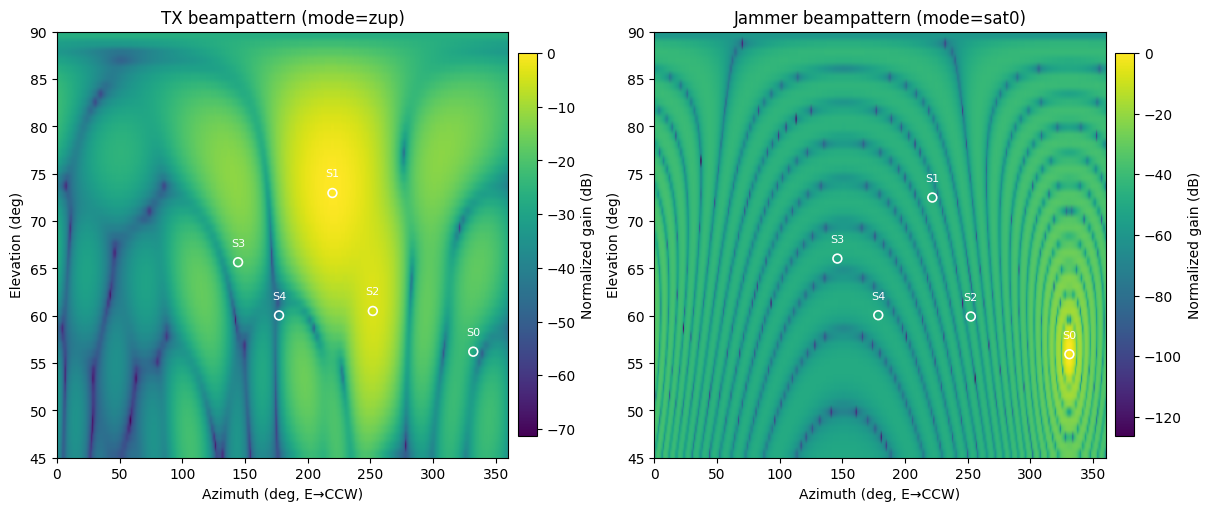

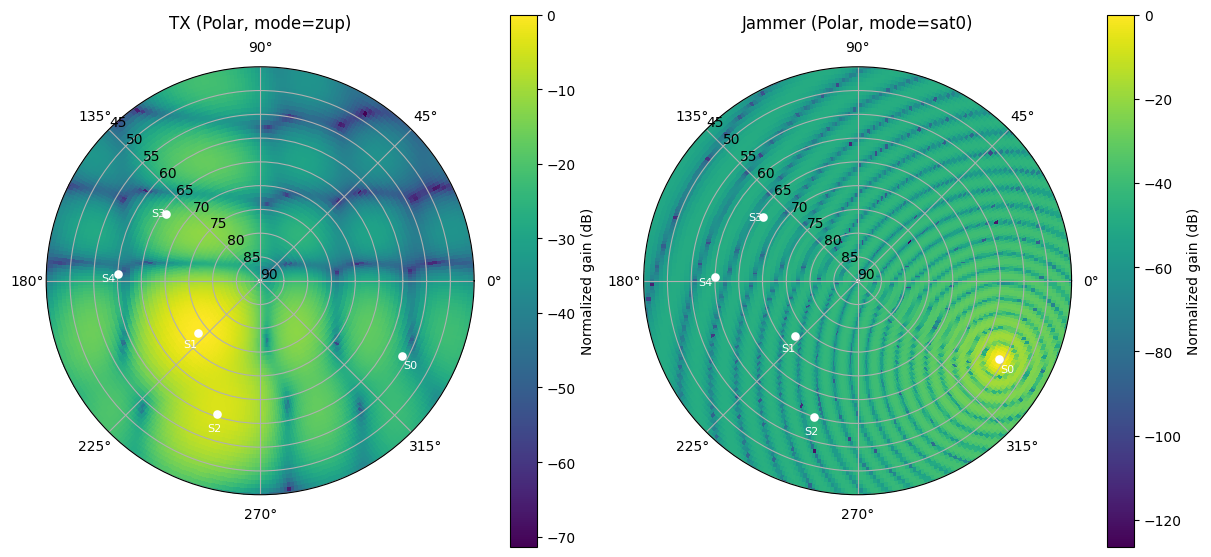

In [9]:
# =========================
# 1) 角度/坐标工具（E-CCW）
# =========================
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv as Jv

def _azel_to_unitvec_eccw(az_deg: float, el_deg: float):
    """E-CCW: 0°=East, CCW positive → unit vector (x=E, y=N, z=U)."""
    az = np.deg2rad(az_deg); el = np.deg2rad(el_deg)
    return np.array([np.cos(el)*np.cos(az), np.cos(el)*np.sin(az), np.sin(el)], dtype=float)

def compute_az_el_dist_math(sat_pos, gnd_pos, frequency_hz: float | None = None):
    """
    返回 az_eccw (E-CCW)、el_deg、dist 以及（可选）n_waves。
    注意：这与 compute_az_el_dist 的 North-CW 输出不同；这是给绘图/steering 用的。
    """
    vec  = sat_pos - gnd_pos
    dist = float(np.linalg.norm(vec))
    dx, dy, dz = vec / (dist + 1e-15)
    el_rad  = np.arcsin(dz)
    az_east = np.arctan2(dy, dx)                              # 0°=East, CCW
    az_eccw = (np.degrees(az_east) + 360.0) % 360.0
    el_deg  = float(np.degrees(el_rad))
    if frequency_hz is not None:
        wavelength = 3e8 / frequency_hz
        n_waves = dist / wavelength
        return az_eccw, el_deg, dist, n_waves
    return az_eccw, el_deg, dist

def make_sat_azel_for_tx_math(tx_pos, sat_positions, freq_hz):
    """为绘图/steering 构造卫星角度（E-CCW）。"""
    out = []
    for sat in sat_positions:
        az_eccw, el_deg, _, _ = compute_az_el_dist_math(sat, tx_pos, freq_hz)
        out.append((az_eccw, max(0.0, min(90.0, el_deg))))
    return out

# =========================
# 2) 元件方向图（以 E-CCW 入参）
# =========================
def tr38901_elem_gain_db_centered(az_deg, el_deg, az0_deg, el0_deg,
                                  Gmax=8.0, phi_3dB=65.0, theta_3dB=65.0,
                                  Am=30.0, SLA_v=30.0):
    """
    TR 38.901 单元方向图（与 Sionna v_tr38901_pattern 一致的简化版）。
    所有角度均为 E-CCW；boresight=(az0_deg, el0_deg) 亦为 E-CCW。
    """
    # 建立以 boresight 为 x' 轴的局部基
    x0 = _azel_to_unitvec_eccw(az0_deg, el0_deg)
    x0 = x0 / (np.linalg.norm(x0) + 1e-15)
    up = np.array([0.0, 0.0, 1.0])
    z0 = up - np.dot(up, x0) * x0
    if np.linalg.norm(z0) < 1e-12:
        alt = np.array([1.0, 0.0, 0.0])
        if abs(np.dot(alt, x0)) > 0.9:
            alt = np.array([0.0, 1.0, 0.0])
        z0 = alt - np.dot(alt, x0) * x0
    z0 = z0 / (np.linalg.norm(z0) + 1e-15)
    y0 = np.cross(z0, x0); y0 = y0 / (np.linalg.norm(y0) + 1e-15)
    R  = np.stack([x0, y0, z0], axis=1)  # 列为局部基

    v_g = _azel_to_unitvec_eccw(az_deg, el_deg)
    v_l = R.T @ v_g  # global→local
    zc  = np.clip(v_l[2], -1.0, 1.0)
    theta = np.arccos(zc)                    # 与 boresight 垂直面的偏离角
    phi   = np.arctan2(v_l[1], v_l[0])       # 方位角（局部）
    theta_deg = np.degrees(theta); phi_deg = np.degrees(phi)

    A_v = -min(12.0*((theta_deg-90.0)/theta_3dB)**2, SLA_v)
    A_h = -min(12.0*((phi_deg)/phi_3dB)**2, Am)
    A   = -min(-(A_v + A_h), Am)
    return float(Gmax + A)

def dish_elem_gain_db_centered(az_deg, el_deg, az0_deg, el0_deg,
                               aperture_radius_lambda=10.0, g_peak_dBi=40.0,
                               back_supp_db=30.0):
    """
    简化 Bessel/Airy 盘天线方向图，E-CCW；boresight=(az0,el0) 为 E-CCW。
    """
    v  = _azel_to_unitvec_eccw(az_deg, el_deg)
    v0 = _azel_to_unitvec_eccw(az0_deg, el0_deg)
    cos_a = np.clip(np.dot(v, v0), -1.0, 1.0)
    alpha = np.arccos(cos_a)
    u = 2.0*np.pi*float(aperture_radius_lambda)*np.sin(alpha)
    eps = 1e-12
    u_safe = np.where(np.abs(u) < eps, eps, u)
    airy = (2.0*Jv(1, u_safe)/u_safe)**2
    airy = np.where(np.abs(u) < eps, 1.0, airy)
    G_lin = (10.0**(g_peak_dBi/10.0))*airy
    G_lin = np.where(alpha > (np.pi/2.0), G_lin*10.0**(-back_supp_db/10.0), G_lin)
    return float(10.0*np.log10(max(G_lin, 1e-30)))

# =========================
# 3) 阵列响应与功率图（E-CCW）
# =========================
def planar_steering_vector(n_rows, n_cols, dx_lambda, dy_lambda, az_deg, el_deg, elem_gain_fn=None):
    k  = 2.0*np.pi
    az = np.deg2rad(az_deg); el = np.deg2rad(el_deg)
    ux = np.cos(el)*np.cos(az); uy = np.cos(el)*np.sin(az)
    c_idx = np.arange(n_cols); r_idx = np.arange(n_rows)
    # phase_x = np.exp(1j*k*dx_lambda*ux*c_idx)
    # phase_y = np.exp(1j*k*dy_lambda*uy*r_idx)
    phase_x = np.exp(-1j*k*dx_lambda*ux*c_idx)
    phase_y = np.exp(-1j*k*dy_lambda*uy*r_idx)
    a = np.kron(phase_y, phase_x).reshape((-1,1))
    if elem_gain_fn is not None:
        g_db = elem_gain_fn(az_deg, el_deg)
        a *= np.sqrt(10.0**(g_db/10.0))  # 场幅乘 √增益
    return a

def spatial_power_map(Q, n_rows, n_cols, az_grid, el_grid, elem_gain_fn=None, dx_lambda=0.5, dy_lambda=0.5):
    N = n_rows*n_cols
    if Q.shape != (N, N):
        raise ValueError(f"Q shape {Q.shape} != ({N},{N}) for {n_rows}x{n_cols}")
    P = np.zeros((len(el_grid), len(az_grid)), dtype=float)
    for i, el in enumerate(el_grid):
        for j, az in enumerate(az_grid):
            a = planar_steering_vector(n_rows, n_cols, dx_lambda, dy_lambda, az, el, elem_gain_fn)
            P[i, j] = float(np.real(a.conj().T @ Q @ a))
    P = np.maximum(P, 1e-16)
    P_db = 10.0*np.log10(P); P_db -= P_db.max()  # 归一到 0 dB 峰值
    return P_db

# =========================
# 4) 绘图（cartesian & polar），轴设为 E-CCW
# =========================
def plot_side_by_side_cartesian(P0_db, P1_db, az_grid, el_grid,
                                sat_tx=None, sat_jam=None,
                                title_left="TX beampattern", title_right="Jammer beampattern",
                                share_limits=False):
    if share_limits:
        vmin = min(P0_db.min(), P1_db.min()); vmax = 0.0
        vlims = [(vmin, vmax), (vmin, vmax)]
    else:
        vlims = [(P0_db.min(), 0.0), (P1_db.min(), 0.0)]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # 左：TX
    ax = axes[0]
    im0 = ax.imshow(P0_db, origin="lower",
                    extent=[az_grid[0], az_grid[-1], el_grid[0], el_grid[-1]],
                    aspect="auto", vmin=vlims[0][0], vmax=vlims[0][1], cmap="viridis")
    ax.set_xlabel("Azimuth (deg, E→CCW)"); ax.set_ylabel("Elevation (deg)")
    ax.set_title(title_left)
    if sat_tx:
        azs = [a for a,_ in sat_tx]; els = [e for _,e in sat_tx]
        ax.scatter(azs, els, s=40, edgecolor="white", facecolor="none", linewidths=1.2)
        for k,(az,el) in enumerate(sat_tx):
            ax.text(az, el+1.5, f"S{k}", color="white", ha="center", va="bottom", fontsize=8)
    cbar0 = fig.colorbar(im0, ax=ax, shrink=0.9, pad=0.02)
    cbar0.set_label("Normalized gain (dB)")

    # 右：Jammer
    ax = axes[1]
    im1 = ax.imshow(P1_db, origin="lower",
                    extent=[az_grid[0], az_grid[-1], el_grid[0], el_grid[-1]],
                    aspect="auto", vmin=vlims[1][0], vmax=vlims[1][1], cmap="viridis")
    ax.set_xlabel("Azimuth (deg, E→CCW)"); ax.set_ylabel("Elevation (deg)")
    ax.set_title(title_right)
    if sat_jam:
        azs = [a for a,_ in sat_jam]; els = [e for _,e in sat_jam]
        ax.scatter(azs, els, s=40, edgecolor="white", facecolor="none", linewidths=1.2)
        for k,(az,el) in enumerate(sat_jam):
            ax.text(az, el+1.5, f"S{k}", color="white", ha="center", va="bottom", fontsize=8)
    cbar1 = fig.colorbar(im1, ax=ax, shrink=0.9, pad=0.02)
    cbar1.set_label("Normalized gain (dB)")

    plt.show()

def plot_side_by_side_polar(P0_db, P1_db, az_grid, el_grid,
                            sat_tx=None, sat_jam=None,
                            title_left="TX beampattern (Polar)", title_right="Jammer beampattern (Polar)",
                            share_limits=False):
    # 轴按 E-CCW：theta=0 在 East，方向 CCW
    az_r = np.deg2rad(az_grid); El = np.array(el_grid)
    Az, Elm = np.meshgrid(az_r, El)

    if share_limits:
        vmin = min(P0_db.min(), P1_db.min()); vmax = 0.0
        vlims = [(vmin, vmax), (vmin, vmax)]
    else:
        vlims = [(P0_db.min(), 0.0), (P1_db.min(), 0.0)]

    fig = plt.figure(figsize=(12, 6), constrained_layout=True)
    ax0 = fig.add_subplot(1, 2, 1, projection="polar")
    ax1 = fig.add_subplot(1, 2, 2, projection="polar")

    # 左：TX
    ax = ax0
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlim(90, 45)
    ax.set_rlabel_position(135)
    ax.set_title(title_left, va="bottom", fontsize=12)
    im0 = ax.pcolormesh(Az, Elm, P0_db, shading="auto", cmap="viridis",
                        vmin=vlims[0][0], vmax=vlims[0][1])
    if sat_tx:
        for k,(az,el) in enumerate(sat_tx):
            ax.plot(np.deg2rad(az), el, 'wo', markersize=5, markeredgewidth=1.2)
            ax.text(np.deg2rad(az), el-2, f"S{k}", color='w', ha='center', va='top', fontsize=8)
    cbar0 = fig.colorbar(im0, ax=ax, shrink=0.9, pad=0.02)
    cbar0.set_label("Normalized gain (dB)")

    # 右：Jammer
    ax = ax1
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlim(90, 45)
    ax.set_rlabel_position(135)
    ax.set_title(title_right, va="bottom", fontsize=12)
    im1 = ax.pcolormesh(Az, Elm, P1_db, shading="auto", cmap="viridis",
                        vmin=vlims[1][0], vmax=vlims[1][1])
    if sat_jam:
        for k,(az,el) in enumerate(sat_jam):
            ax.plot(np.deg2rad(az), el, 'wo', markersize=5, markeredgewidth=1.2)
            ax.text(np.deg2rad(az), el-2, f"S{k}", color='w', ha='center', va='top', fontsize=8)
    cbar1 = fig.colorbar(im1, ax=ax, shrink=0.9, pad=0.02)
    cbar1.set_label("Normalized gain (dB)")

    plt.show()

# =========================
# 5) 主入口：几何联动 + 绘图
# =========================
def draw_tx_and_jam_radiomap(
    Q0, Q1,
    gnd_positions, sat_positions,
    tx_rows, tx_cols,
    jam_rows, jam_cols,
    frequency_hz=10e9,
    tx_mode="sat0",            # "sat0" or "zup"
    jam_mode="sat0",           # "sat0" or "zup"
    jam_aperture_radius_lambda=10.0,
    jam_Gpeak=40.0,
    jam_back_supp=30.0,
    tx_Gmax=8.0,
    use_absolute_power=False,
    P0_watt=None, P1_watt=None
):
    # 角度网格（E-CCW）
    # delta_deg = 90
    # az_grid = (np.linspace(0, 360, 361)+delta_deg)%360
    az_grid = np.linspace(0, 360, 361)
    el_grid = np.linspace(45, 90, 51)

    # 计算卫星相对 TX0/JAM 的角（E-CCW）
    sat_azel_tx0  = make_sat_azel_for_tx_math(gnd_positions[0], sat_positions, frequency_hz)
    sat_azel_jam  = make_sat_azel_for_tx_math(gnd_positions[1], sat_positions, frequency_hz)

    # 选择 boresight（E-CCW）
    if tx_mode.lower() == "zup": az0_tx, el0_tx = 0.0, 90.0
    else:                        az0_tx, el0_tx = sat_azel_tx0[0]

    if jam_mode.lower() == "zup": az0_jm, el0_jm = 0.0, 90.0
    else:                         az0_jm, el0_jm = sat_azel_jam[0]

    # 元件方向图（E-CCW）
    tx_elem_fn  = lambda az,el: tr38901_elem_gain_db_centered(
        az, el, az0_tx, el0_tx, Gmax=tx_Gmax, phi_3dB=65.0, theta_3dB=65.0, Am=30.0, SLA_v=30.0
    )
    jam_elem_fn = lambda az,el: dish_elem_gain_db_centered(
        az, el, az0_jm, el0_jm, aperture_radius_lambda=jam_aperture_radius_lambda,
        g_peak_dBi=jam_Gpeak, back_supp_db=jam_back_supp
    )

    # 计算功率图（相对峰值）
    P0_db = spatial_power_map(Q0, tx_rows, tx_cols, az_grid, el_grid, tx_elem_fn)
    P1_db = spatial_power_map(Q1, jam_rows, jam_cols, az_grid, el_grid, jam_elem_fn)
    
    
    
    # # --- 仅旋转左图（TX）的 radiomap 与标注：逆时针 180° ---
    # rot_deg = 180
    # # 角度步长（容错：不一定是 1° ）
    # daz = float(az_grid[1] - az_grid[0])
    # shift_cols = int(round(rot_deg / daz)) % P0_db.shape[1]
    # # 1) 图像列维度 axis=1 对应 az_grid；每 1 列≈1°
    # P0_db_rot = np.roll(P0_db, shift=rot_deg, axis=1)
    
    
    
    
    # 可选：叠加绝对功率
    if use_absolute_power and (P0_watt is not None) and (P1_watt is not None):
        P0_db = P0_db + 10.0*np.log10(max(P0_watt, 1e-30))
        P1_db = P1_db + 10.0*np.log10(max(P1_watt, 1e-30))

    # 绘图（轴制式=E-CCW）
    plot_side_by_side_cartesian(P0_db, P1_db, az_grid, el_grid,
                                sat_tx=sat_azel_tx0, sat_jam=sat_azel_jam,
                                title_left=f"TX beampattern (mode={tx_mode})",
                                title_right=f"Jammer beampattern (mode={jam_mode})",
                                share_limits=False)

    plot_side_by_side_polar(P0_db, P1_db, az_grid, el_grid,
                            sat_tx=sat_azel_tx0, sat_jam=sat_azel_jam,
                            title_left=f"TX (Polar, mode={tx_mode})",
                            title_right=f"Jammer (Polar, mode={jam_mode})",
                            share_limits=False)

# =========================
# 6) （可选）一致性自检
# =========================
def sanity_check_angles(gnd0, sat_positions, freq_hz):
    sat_azel = make_sat_azel_for_tx_math(gnd0, sat_positions, freq_hz)
    for k, (az_eccw, el) in enumerate(sat_azel):
        v_plot = _azel_to_unitvec_eccw(az_eccw, el)
        v_geom = sat_positions[k] - gnd0
        v_geom = v_geom / (np.linalg.norm(v_geom) + 1e-15)
        err = np.degrees(np.arccos(np.clip(np.dot(v_plot, v_geom), -1, 1)))
        print(f"[sanity] S{k} angle error (deg): {err:.3e}")
# 假设你已有：
# Q0, Q1               # from optimal_Q0(...)
# gnd_positions        # 形如 [[0,0,0], jammer_offset, ...]（本地 ENU）
# sat_positions        # 由 compute_satellite_intersection_point_enu(...) 默认 tx_pos 生成的本地 ENU
# tx_rows, tx_cols
# jam_rows, jam_cols
# frequency_hz = 10e9
# P0_watt, P1_watt 可选

sanity_check_angles(gnd_positions[0], sat_positions, frequency_hz)  # 可选，一次就能发现不一致

draw_tx_and_jam_radiomap(
    Q0, Q1,
    gnd_positions, sat_positions,
    tx_rows, tx_cols,
    jam_rows, jam_cols,
    frequency_hz=frequency_hz,
    tx_mode="zup",              # 或 "sat0"
    jam_mode="sat0",
    jam_aperture_radius_lambda=10.0,
    jam_Gpeak=40.0,
    jam_back_supp=30.0,
    tx_Gmax=8.0,
    use_absolute_power=False,
    P0_watt=None, P1_watt=None
)
